# Final Assignment

|***Project***|***Analysis of Chicago Real Estate Market***|
|---:|:---|
|**Subject**|Machine Learning|
|**Assignment**|Final Assignment|
|**Team Name**|Group 4|
|**Team Members**|Mary Kate Krusenoski<br>Yunhao Dou<br>Phill Betts<br>Zijun Wu|

# Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import datetime as dt
import missingno as msno
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import Ridge 

# suppressing pesky warnings

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
import json

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Preprocessing

## Loading Data

In [2]:
# Read the file containing the data from redfin
df = pd.read_excel ('Sold_05222022.xlsx')

#Chicago Crime 2021
dfCrime = pd.read_csv ('ChiCrime.csv')

### Removing Extra Columns

In [3]:
df.head()

Source.Name  SALE TYPE  SOLD DATE PROPERTY TYPE                 ADDRESS  \
0  Jun2021.csv  PAST SALE 2019-02-25     Townhouse       1513 W Orchard Pl   
1  Jun2021.csv  PAST SALE 2018-11-16     Townhouse  204 W Hyde St Unit 9-2   
2  Jun2021.csv  PAST SALE 2019-11-27     Townhouse        2732 S Embers Ln   
3  Jun2021.csv  PAST SALE 2018-02-13     Townhouse     109 S Evergreen Ave   
4  Jun2021.csv  PAST SALE 2019-03-30     Townhouse           222 W Hyde St   

                CITY STATE OR PROVINCE  ZIP OR POSTAL CODE     PRICE  BEDS  \
0  Arlington Heights                IL               60005  257000.0   3.0   
1  Arlington Heights                IL               60005  285000.0   2.0   
2  Arlington Heights                IL               60005  265000.0   3.0   
3  ARLINGTON HEIGHTS                IL               60005  395000.0   3.0   
4  Arlington Heights                IL               60005  277500.0   2.0   

   ...  STATUS NEXT OPEN HOUSE START TIME  NEXT OPEN HOUSE END TIME  \
0  ...    Sold                        NaN                       NaN   
1  ...    Sold                        NaN                       NaN   
2  ...    Sold                        NaN                       NaN   
3  ...    Sold                        NaN                       NaN   
4  ...    Sold                        NaN                       NaN   

   URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)  \
0  http://www.redfin.com/IL/Arlington-Heights/151...                                            
1  http://www.redfin.com/IL/Arlington-Heights/204...                                            
2  http://www.redfin.com/IL/Arlington-Heights/273...                                            
3  http://www.redfin.com/IL/Arlington-Heights/109...                                            
4  http://www.redfin.com/IL/Arlington-Heights/222...                                            

   SOURCE        MLS#  FAVORITE  INTERESTED   LATITUDE  LONGITUDE  
0    MRED  10249755.0         N           Y  42.067591 -88.000669  
1    MRED  10081414.0         N           Y  42.047216 -87.986124  
2    MRED  10561351.0         N           Y  42.036228 -87.972024  
3    MRED   9790281.0         N           Y  42.080651 -87.981234  
4    MRED  10170522.0         N           Y  42.047205 -87.986561  

[5 rows x 28 columns]

In [4]:
# drop the columns that are not needed for building the model
df=df.drop(['Source.Name','SALE TYPE','STATE OR PROVINCE','STATUS',
            'NEXT OPEN HOUSE START TIME',
            'NEXT OPEN HOUSE END TIME', 
            'FAVORITE', 
            'INTERESTED',
            'MLS#',
            'STATUS',
            'STATE OR PROVINCE',
            'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',#has missing data
            'SOURCE',
            '$/SQUARE FEET'
           ], axis=1)
#keep address for identification later
# remove special character as well as spaces in between column names
# removing them helps later in processing
df.columns = df.columns.str.replace(' ', '')

In [5]:
#For testing imputation methods
df1 = df.copy()

In [6]:
df = df1.copy()

### Combining Crimes Data

In [7]:
dfCrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211337 entries, 0 to 211336
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            211337 non-null  int64  
 1   ID                    211337 non-null  int64  
 2   Case Number           211337 non-null  object 
 3   Date                  211337 non-null  object 
 4   Block                 211337 non-null  object 
 5   IUCR                  211337 non-null  object 
 6   Primary Type          211337 non-null  object 
 7   Description           211337 non-null  object 
 8   Location Description  210493 non-null  object 
 9   Arrest                211337 non-null  bool   
 10  Domestic              211337 non-null  bool   
 11  Beat                  211337 non-null  int64  
 12  District              211337 non-null  float64
 13  Ward                  211326 non-null  float64
 14  Community Area        211336 non-null  float64
 15  

In [8]:
#october 31 2020 - 2021
dfCrime.head()

Unnamed: 0        ID Case Number                 Date  \
0       54817  12243263    JD456923  2020-12-11 19:15:00   
1       59650  12245122    JD458715  2020-12-11 18:00:00   
2       64403  12222985    JD433414  2020-11-16 20:11:00   
3       64425  12227361    JD438487  2020-11-21 20:00:00   
4       64503  12230635    JD442373  2020-11-25 02:00:00   

                     Block  IUCR         Primary Type  \
0      070XX N WESTERN AVE  0610             BURGLARY   
1     019XX N LAWNDALE AVE  0810                THEFT   
2  032XX W WASHINGTON BLVD  1544          SEX OFFENSE   
3   050XX S CHRISTIANA AVE  0910  MOTOR VEHICLE THEFT   
4     020XX S MICHIGAN AVE  1477    WEAPONS VIOLATION   

                      Description Location Description  Arrest  ...  Ward  \
0                  FORCIBLE ENTRY           BARBERSHOP   False  ...  50.0   
1                       OVER $500   RESIDENCE - GARAGE   False  ...  26.0   
2  SEXUAL EXPLOITATION OF A CHILD            RESIDENCE   False  ...  28.0   
3                      AUTOMOBILE               STREET    True  ...  14.0   
4      RECKLESS FIREARM DISCHARGE            APARTMENT   False  ...   3.0   

   Community Area  FBI Code  X Coordinate  Y Coordinate  Year  \
0             2.0        05     1159045.0     1946546.0  2020   
1            22.0        06           NaN           NaN  2020   
2            27.0        17     1154712.0     1900497.0  2020   
3            63.0        07     1154895.0     1870928.0  2020   
4            33.0        15     1177530.0     1890539.0  2020   

               Updated On   Latitude  Longitude                       Location  
0  12/18/2020 03:51:11 PM  42.009054 -87.690172   (42.00905433, -87.690172193)  
1  12/18/2020 03:51:11 PM        NaN        NaN                            NaN  
2  12/18/2020 03:48:35 PM  41.882781 -87.707352  (41.882780879, -87.707351971)  
3  12/18/2020 03:48:35 PM  41.801636 -87.707471  (41.801636338, -87.707471206)  
4  12/18/2020 03:48:35 PM  41.854968 -87.623866  (41.854968236, -87.623866311)  

[5 rows x 23 columns]

In [9]:
#Converting Community Area from numerical data to neighborhood to merge with Redfin LOCATION data
dfCrime["Community Area"] = dfCrime["Community Area"].astype(str)
Communitydict = {
'1.0':'Rogers Park',
'2.0':'West Ridge',
'3.0':'Uptown',
'4.0':'Lincoln Square',
'5.0':'North Center',
'6.0':'Lakeview',
'7.0':'Lincoln Park',
'8.0':'Near North Side',
'9.0':'Edison Park',
'10.0':'Norwood Park',
'11.0':'Jefferson Park',
'12.0':'Forest Glen',
'13.0':'North Park',
'14.0':'Albany Park',
'15.0':'Portage Park',
'16.0':'Irving Park',
'17.0':'Dunning',
'18.0':'Montclare',
'19.0':'Belmont Cragin',
'20.0':'Hermosa',
'21.0':'Avondale',
'22.0':'Logan Square',
'23.0':'Humboldt Park',
'24.0':'West Town',
'25.0':'Austin',
'26.0':'West Garfield Park',
'27.0':'East Garfield Park',
'28.0':'Near West Side',
'29.0':'North Lawndale',
'30.0':'South Lawndale',
'31.0':'Lower West Side',
'32.0':'Loop',
'33.0':'Near South Side',
'34.0':'Armour Square',
'35.0':'Douglas',
'36.0':'Oakland',
'37.0':'Fuller Park',
'38.0':'Grand Boulevard',
'39.0':'Kenwood',
'40.0':'Washington Park',
'41.0':'Hyde Park',
'42.0':'Woodlawn',
'43.0':'South Shore',
'44.0':'Chatham',
'45.0':'Avalon Park',
'46.0':'South Chicago',
'47.0':'Burnside',
'48.0':'Calumet Heights',
'49.0':'Roseland',
'50.0':'Pullman',
'51.0':'South Deering',
'52.0':'East Side',
'53.0':'West Pullman',
'54.0':'Riverdale',
'55.0':'Hegewisch',
'56.0':'Garfield Ridge',
'57.0':'Archer Heights',
'58.0':'Brighton Park',
'59.0':'McKinley Park',
'60.0':'Bridgeport',
'61.0':'New City',
'62.0':'West Elsdon',
'63.0':'Gage Park',
'64.0':'Clearing',
'65.0':'West Lawn',
'66.0':'Chicago Lawn',
'67.0':'West Englewood',
'68.0':'Englewood',
'69.0':'Greater Grand Crossing',
'70.0':'Ashburn',
'71.0':'Auburn Gresham',
'72.0':'Beverly',
'73.0':'Washington Heights',
'74.0':'Mount Greenwood',
'75.0':'Morgan Park',
'76.0':'O Hare',
'77.0':'Edgewater'
}
dfCrime["Community Area"] = dfCrime["Community Area"].map(Communitydict)

In [10]:
#Crime by type
dfCrime['Primary Type'].value_counts()

BATTERY                              41247
THEFT                                39617
CRIMINAL DAMAGE                      25433
ASSAULT                              20239
DECEPTIVE PRACTICE                   19889
OTHER OFFENSE                        13936
MOTOR VEHICLE THEFT                  10623
WEAPONS VIOLATION                     9609
ROBBERY                               7859
BURGLARY                              6561
NARCOTICS                             5075
CRIMINAL TRESPASS                     3488
OFFENSE INVOLVING CHILDREN            1894
CRIMINAL SEXUAL ASSAULT               1393
SEX OFFENSE                           1019
HOMICIDE                               835
PUBLIC PEACE VIOLATION                 638
ARSON                                  555
INTERFERENCE WITH PUBLIC OFFICER       374
STALKING                               330
CONCEALED CARRY LICENSE VIOLATION      184
LIQUOR LAW VIOLATION                   141
INTIMIDATION                           132
KIDNAPPING 

In [11]:
#We want to aggregate total crimes for the year per Community Area
crimeCountLocation = pd.DataFrame(dfCrime['Community Area'].value_counts().reset_index().values, columns=['Community Area', "AggregateCrime"])
crimeCountindex = crimeCountLocation.sort_index(axis = 0, ascending=True)
crimeCountindex

Community Area AggregateCrime
0            Austin          12191
1   Near North Side           7737
2       South Shore           7684
3    Near West Side           6710
4    North Lawndale           6665
..              ...            ...
72  Mount Greenwood            565
73      Forest Glen            556
74        Montclare            553
75         Burnside            335
76      Edison Park            287

[77 rows x 2 columns]

In [12]:
#Removing Locations with unmappable characters
df['LOCATION']=df['LOCATION'].str.replace('CHI - ','')

In [13]:
df = pd.merge(df, crimeCountindex, how='left', left_on='LOCATION', right_on='Community Area')
df.head()

SOLDDATE PROPERTYTYPE                 ADDRESS               CITY  \
0 2019-02-25    Townhouse       1513 W Orchard Pl  Arlington Heights   
1 2018-11-16    Townhouse  204 W Hyde St Unit 9-2  Arlington Heights   
2 2019-11-27    Townhouse        2732 S Embers Ln  Arlington Heights   
3 2018-02-13    Townhouse     109 S Evergreen Ave  ARLINGTON HEIGHTS   
4 2019-03-30    Townhouse           222 W Hyde St  Arlington Heights   

   ZIPORPOSTALCODE     PRICE  BEDS  BATHS           LOCATION  SQUAREFEET  \
0            60005  257000.0   3.0    2.5  Arlington Heights         NaN   
1            60005  285000.0   2.0    3.0  Arlington Heights      2025.0   
2            60005  265000.0   3.0    3.0  Arlington Heights      1795.0   
3            60005  395000.0   3.0    3.5  Arlington Heights      1981.0   
4            60005  277500.0   2.0    3.0  Arlington Heights      2025.0   

   LOTSIZE  YEARBUILT  DAYSONMARKET  HOA/MONTH   LATITUDE  LONGITUDE  \
0      NaN     1989.0         811.0      330.0  42.067591 -88.000669   
1   2025.0     2011.0         912.0      339.0  42.047216 -87.986124   
2      NaN        NaN         536.0      290.0  42.036228 -87.972024   
3   1111.0     1999.0        1188.0      206.0  42.080651 -87.981234   
4      NaN     2009.0         778.0      338.0  42.047205 -87.986561   

  Community Area AggregateCrime  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN

In [14]:
#Dropping merged location column
df=df.drop(['Community Area'],axis = 1)

### Data Mapping

In [15]:
#Reviewing all property types. We will only include top 3 in our analysis
df['PROPERTYTYPE'].value_counts()

Single Family Residential    39934
Condo/Co-op                  33324
Townhouse                     7668
Multi-Family (2-4 Unit)         45
Other                           24
Multi-Family (5+ Unit)          17
Vacant Land                     13
Parking                          1
Unknown                          1
Name: PROPERTYTYPE, dtype: int64

In [16]:
# converting the sold date field to a proper date time format
df['SOLDDATE'] = pd.to_datetime(df['SOLDDATE'])
df['SOLDDATE']=pd.DatetimeIndex(df['SOLDDATE']).year
df.dropna(subset = ['SOLDDATE'], inplace=True)
df['SOLDDATE']=df['SOLDDATE'].astype(int)

In [17]:
df['CITY'] = df.CITY.str.upper()

In [18]:
#Removing Arlington Heights
df = df[df['CITY'] != 'ARLINGTON HEIGHTS']

In [19]:
df['CITY'].value_counts()

CHICAGO            56329
OAK PARK            5470
OAK LAWN            2067
BERWYN              1472
RIVER FOREST        1095
FOREST PARK         1061
BURBANK              759
ELMWOOD PARK         708
EVERGREEN PARK       672
CICERO               576
HOMETOWN             268
STICKNEY             232
LINCOLNWOOD          225
HARWOOD HEIGHTS      224
BRIDGEVIEW           209
MAYWOOD              153
MELROSE PARK         126
SKOKIE                91
NORRIDGE              89
RIVERSIDE             88
NORTH RIVERSIDE       35
RIVER GROVE           30
FOREST VIEW           25
BURNHAM               25
RIVERDALE             23
CALUMET PARK          19
NOTTINGHAM PARK        9
LAWNDALE               2
NILES                  1
Name: CITY, dtype: int64

In [20]:
#For listing on Cities
df1 = df.copy()

In [21]:
#Mapping data to numerical values
mapping_dict = {"PROPERTYTYPE":{
"Condo/Co-op": 1,
"Single Family Residential": 2,
"Townhouse": 3,
"Multi-Family (2-4 Unit)": 4,
"Multi-Family (5+ Unit)": 5,
"Other": 6,
"Vacant Land": 7,
"Parking":8
},
"CITY":{
'CHICAGO' : 1,
'OAK PARK' : 0,
'OAK LAWN' : 0,
'BERWYN' : 0,
'BURBANK' : 0,
'EVERGREEN PARK' : 0,
'ELMWOOD PARK' : 0,
'FOREST PARK' : 0,
'CICERO' : 0,
'RIVER FOREST' : 0,
'HOMETOWN' : 0,
'STICKNEY' : 0,
'LINCOLNWOOD' : 0,
'HARWOOD HEIGHTS' : 0,
'BRIDGEVIEW' : 0,
'SKOKIE' : 0,
'NORRIDGE' : 0,
'RIVERSIDE' : 0,
'NORTH RIVERSIDE' : 0,
'RIVER GROVE' : 0,
'BURNHAM' : 0,
'FOREST VIEW' : 0,
'RIVERDALE' : 0,
'CALUMET PARK' : 0,
'MELROSE PARK' : 0,
'NOTTINGHAM PARK' : 0,
'LAWNDALE' : 0,
'MAYWOOD' : 0,
'NILES' : 0},
"SOLDDATE":{
2016: 1,
2017: 2,
2018: 3,
2019: 4,
2020: 5,
2021: 6,
2022: 7    
}
               }
df = df.replace(mapping_dict)

#changing numerical datatypes
df['PROPERTYTYPE'] = df['PROPERTYTYPE'].astype('str')
df['CITY'] = df['CITY'].astype('str')
df['LOCATION'] = df['LOCATION'].astype('str')
df['SOLDDATE'] = df['SOLDDATE'].astype('int')


catmap = preprocessing.LabelEncoder()
df['PROPERTYTYPE'] = catmap.fit_transform(df['PROPERTYTYPE'].values)
df['LOCATION'] = catmap.fit_transform(df['LOCATION'].values)
df['CITY'] = catmap.fit_transform(df['CITY'].values)
df['ZIPORPOSTALCODE'] = catmap.fit_transform(df['ZIPORPOSTALCODE'].values)
df['YEARBUILT'] = catmap.fit_transform(df['YEARBUILT'].values)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72083 entries, 924 to 81026
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SOLDDATE         72083 non-null  int32  
 1   PROPERTYTYPE     72083 non-null  int32  
 2   ADDRESS          72083 non-null  object 
 3   CITY             72083 non-null  int32  
 4   ZIPORPOSTALCODE  72083 non-null  int64  
 5   PRICE            72083 non-null  float64
 6   BEDS             72081 non-null  float64
 7   BATHS            72081 non-null  float64
 8   LOCATION         72083 non-null  int32  
 9   SQUAREFEET       60696 non-null  float64
 10  LOTSIZE          37718 non-null  float64
 11  YEARBUILT        72083 non-null  int64  
 12  DAYSONMARKET     63565 non-null  float64
 13  HOA/MONTH        33812 non-null  float64
 14  LATITUDE         65690 non-null  float64
 15  LONGITUDE        65690 non-null  float64
 16  AggregateCrime   50023 non-null  object 
dtypes: float64

In [23]:
#Removing Multi-Family, Vacant lots, or Other property types
df = df[df['PROPERTYTYPE'] < 4] 

In [24]:
df.shape

(72081, 17)

In [25]:
df.head()

SOLDDATE  PROPERTYTYPE                ADDRESS  CITY  ZIPORPOSTALCODE  \
924         4             2  7541 Brown Ave Unit E     0                3   
925         5             2  7541 Brown Ave Unit B     0                3   
926         6             2  7521 Brown Ave Unit H     0                3   
927         3             2         821 Dunlop Ave     0                3   
928         6             2  7521 Brown Ave Unit E     0                3   

        PRICE  BEDS  BATHS  LOCATION  SQUAREFEET  LOTSIZE  YEARBUILT  \
924  290000.0   2.0    2.0       193      2100.0      NaN        142   
925  326500.0   3.0    3.0       193      2300.0      NaN        141   
926  288750.0   2.0    2.5       193      2100.0      NaN        142   
927  290000.0   2.0    3.5       193      1826.0  31250.0        146   
928  330000.0   2.0    2.5       193      2200.0      NaN        145   

     DAYSONMARKET  HOA/MONTH   LATITUDE  LONGITUDE AggregateCrime  
924         639.0      282.0  41.886429 -87.813905            NaN  
925         291.0      333.0  41.886429 -87.813905            NaN  
926          23.0      316.0  41.886257 -87.812984            NaN  
927        1003.0      250.0  41.871205 -87.815922            NaN  
928          12.0      316.0  41.886257 -87.812984            NaN

### Removing Duplicate rows

In [26]:
# Since the data collection was done by multiple team members, 
# there is a chance there are duplicates
df.drop_duplicates(keep='first',inplace=True)
df1.drop_duplicates(keep='first',inplace=True)

### Listings per City

<Figure size 432x288 with 0 Axes>

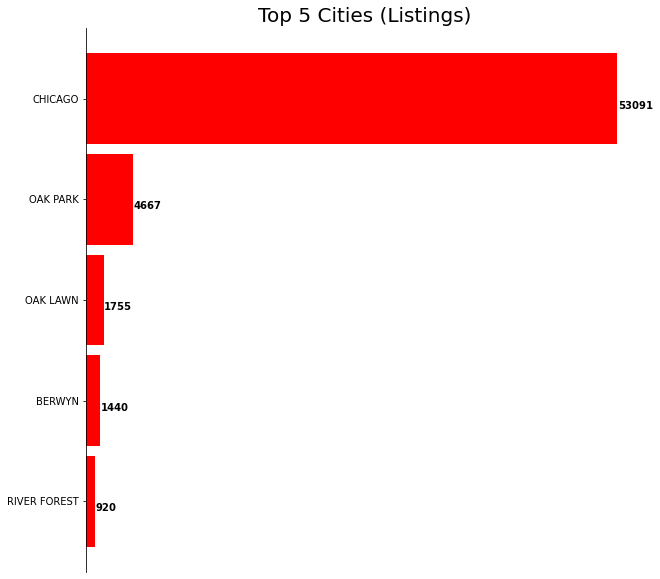

In [27]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
feq=df1['CITY'].value_counts().nlargest(5).sort_values(ascending=True)
feq.plot.barh(figsize=(10, 10), color="red", width=0.9)
plt.title("Top 5 Cities (Listings)", fontsize=20)
for i, v in enumerate(feq):
    ax.text(v + 75, i - 0.1, str(v), color="black", fontweight='bold')
ax.set_xticks([])
plt.show()
#fig.savefig('./Photos/Top5.png', transparent=True)

### Removing Null Values

In [28]:
df.shape

(67067, 17)

In [29]:
#Drop Blank Latitudes that account for a large missing portion of the data, including price
df.dropna(subset = ['LATITUDE'], inplace=True)

In [30]:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(33)

Total     %
HOA/MONTH        30710  50.6
LOTSIZE          30264  49.9
AggregateCrime   19373  31.9
SQUAREFEET       10041  16.5
DAYSONMARKET      7216  11.9
LONGITUDE            0   0.0
LATITUDE             0   0.0
YEARBUILT            0   0.0
SOLDDATE             0   0.0
PROPERTYTYPE         0   0.0
BATHS                0   0.0
BEDS                 0   0.0
PRICE                0   0.0
ZIPORPOSTALCODE      0   0.0
CITY                 0   0.0
ADDRESS              0   0.0
LOCATION             0   0.0

In [31]:
df.groupby(['SOLDDATE']).mean()

PROPERTYTYPE      CITY  ZIPORPOSTALCODE          PRICE      BEDS  \
SOLDDATE                                                                     
1             0.801120  0.769662        46.411980  348823.597285  3.034260   
2             0.782033  0.733480        44.736986  369656.849669  3.038556   
3             0.788992  0.707225        43.007811  391352.989627  3.036002   
4             0.784824  0.716810        43.353019  386864.309573  3.037759   
5             0.802138  0.719302        44.048959  404000.320765  3.071694   
6             0.508947  0.848110        45.806570  458236.119728  2.835337   
7             0.438737  0.885144        46.263777  454896.823970  2.837881   

             BATHS    LOCATION   SQUAREFEET        LOTSIZE   YEARBUILT  \
SOLDDATE                                                                 
1         2.293310  295.433958  1717.106497  105329.607674  107.758888   
2         2.302544  305.141763  1751.336002   33719.461588  107.752304   
3         2.312027  306.817183  1768.087104   31377.252725  108.341713   
4         2.303431  307.704587  1780.411980    4767.972468  108.439671   
5         2.339026  311.045582  1825.550879    4593.237631  107.859651   
6         2.282291  343.444796  1747.888584   38283.257676  118.472412   
7         2.254147  353.814874  1726.521536  257842.182947  118.904762   

          DAYSONMARKET   HOA/MONTH   LATITUDE  LONGITUDE  
SOLDDATE                                                  
1          1719.419737  382.727485  41.868859 -87.710772  
2          1407.046454  382.558708  41.870519 -87.713179  
3          1045.332098  394.066924  41.871104 -87.714941  
4           677.714473  385.359161  41.870310 -87.714194  
5           298.490093  391.165271  41.873421 -87.703967  
6           191.982110  445.173146  41.892170 -87.689628  
7            42.286085  434.227673  41.892662 -87.684741

In [32]:
#median price over time
table = pd.pivot_table(df, values='PRICE',columns=['SOLDDATE'], aggfunc=np.median)
table

SOLDDATE         1         2         3         4         5         6         7
PRICE     269000.0  290000.0  309000.0  310000.0  339000.0  410000.0  425000.0

### Imputing Null Values

In [33]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

<Figure size 432x288 with 0 Axes>

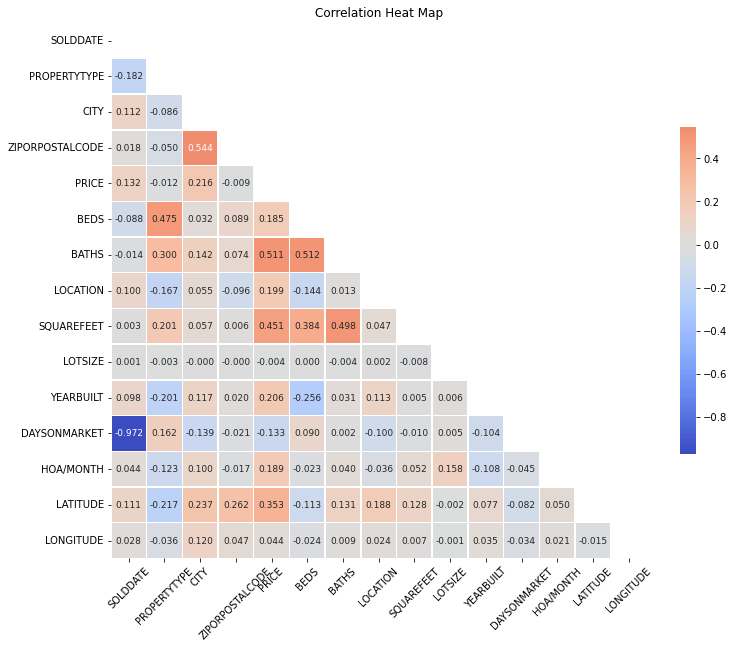

In [34]:
# with correlation matrix/heat map
corr_chart(df_corr = df) 

In [35]:
#Imputing SQ Feet based on KNN nearest neighbors
import sklearn.impute
from sklearn.impute import SimpleImputer, KNNImputer
knniputer = KNNImputer()
knniputer.fit(df[["SQUAREFEET"]])
df["SQUAREFEET"] = knniputer.transform(df[["SQUAREFEET"]])
df["SQUAREFEET"] = df["SQUAREFEET"].apply(lambda x: int(x))
df["SQUAREFEET"].unique()

array([2100, 2300, 1826, ..., 4259, 2868, 2887], dtype=int64)

In [36]:
#impute HOA/ Month with zero.
#Assuming those without HOA's are likely houses without HOA's
df['HOA/MONTH'] = df['HOA/MONTH'].fillna(0)

In [37]:
#Dropping Days on Market and Lot Size since there is no correlation nor impact
df=df.drop(['DAYSONMARKET', 'LOTSIZE'],axis=1)

In [38]:
#impute aggregate crime with the median
df['AggregateCrime']=df['AggregateCrime'].fillna(df['AggregateCrime'].median())

In [39]:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(33)

Total    %
SOLDDATE             0  0.0
PROPERTYTYPE         0  0.0
ADDRESS              0  0.0
CITY                 0  0.0
ZIPORPOSTALCODE      0  0.0
PRICE                0  0.0
BEDS                 0  0.0
BATHS                0  0.0
LOCATION             0  0.0
SQUAREFEET           0  0.0
YEARBUILT            0  0.0
HOA/MONTH            0  0.0
LATITUDE             0  0.0
LONGITUDE            0  0.0
AggregateCrime       0  0.0

In [40]:
df.dropna(inplace=True)

In [41]:
#Longitude has error '0' in data and two large homes with 10000 square feet
df = df[df['LONGITUDE'] != 0]
df = df[df['SQUAREFEET'] < 9999]

In [42]:
#post clean data this is the final size of our dataset
df.shape

(60667, 15)

## Quick Visualization

Quick visualization to see obvious gaps in data

In [43]:
m=folium.Map([41.85, -87.68],zoom_start=11)
HeatMap(df[['LATITUDE','LONGITUDE']].dropna(),radius=8,gradient={0.25:'blue',0.5:'purple',0.75:'orange',1.0:'red'}).add_to(m)
display(m)

In [44]:
# Removing zip codes related to Arlington heights
df=df[~df.ZIPORPOSTALCODE.isin([60004, 60005, 60006, 60008, 60056, 60095])]

In [45]:
df[df['CITY'] == 'Arlington Heights']['ZIPORPOSTALCODE'].value_counts()

Series([], Name: ZIPORPOSTALCODE, dtype: int64)

In [46]:
m=folium.Map([41.85, -87.68],zoom_start=11)
HeatMap(df[['LATITUDE','LONGITUDE']].dropna(),radius=8,gradient={0.25:'blue',0.5:'purple',0.75:'orange',1.0:'red'}).add_to(m)
display(m)

# Other Visualization

In [47]:
lats2018 = df['LATITUDE'].tolist()
lons2018 = df['LONGITUDE'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[41.85, -87.68], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

## Exploratory Data Analysis

### Feature Analysis

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60667 entries, 924 to 81026
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SOLDDATE         60667 non-null  int32  
 1   PROPERTYTYPE     60667 non-null  int32  
 2   ADDRESS          60667 non-null  object 
 3   CITY             60667 non-null  int32  
 4   ZIPORPOSTALCODE  60667 non-null  int64  
 5   PRICE            60667 non-null  float64
 6   BEDS             60667 non-null  float64
 7   BATHS            60667 non-null  float64
 8   LOCATION         60667 non-null  int32  
 9   SQUAREFEET       60667 non-null  int64  
 10  YEARBUILT        60667 non-null  int64  
 11  HOA/MONTH        60667 non-null  float64
 12  LATITUDE         60667 non-null  float64
 13  LONGITUDE        60667 non-null  float64
 14  AggregateCrime   60667 non-null  float64
dtypes: float64(7), int32(4), int64(3), object(1)
memory usage: 6.5+ MB


In [49]:
df.describe()

SOLDDATE  PROPERTYTYPE          CITY  ZIPORPOSTALCODE  \
count  60667.000000  60667.000000  60667.000000     60667.000000   
mean       4.378130      0.677815      0.775216        44.790281   
std        1.820035      0.646710      0.417444        23.120154   
min        1.000000      0.000000      0.000000         0.000000   
25%        3.000000      0.000000      1.000000        28.000000   
50%        5.000000      1.000000      1.000000        43.000000   
75%        6.000000      1.000000      1.000000        67.000000   
max        7.000000      3.000000      1.000000        87.000000   

              PRICE          BEDS         BATHS      LOCATION    SQUAREFEET  \
count  6.066700e+04  60667.000000  60667.000000  60667.000000  60667.000000   
mean   4.116232e+05      2.965813      2.298276    321.311932   1759.535827   
std    2.732302e+05      0.866003      0.679145    177.416103    678.195435   
min    1.100000e+03      0.000000      0.500000      0.000000      0.000000   
25%    2.300000e+05      2.000000      2.000000    192.000000   1300.000000   
50%    3.525000e+05      3.000000      2.000000    324.000000   1760.000000   
75%    5.350000e+05      4.000000      2.500000    401.000000   2000.000000   
max    6.364850e+06     10.000000     42.000000    654.000000   9500.000000   

          YEARBUILT     HOA/MONTH      LATITUDE     LONGITUDE  AggregateCrime  
count  60667.000000  60667.000000  60667.000000  60667.000000    60667.000000  
mean     112.042214    204.853990     41.879113    -87.704092     3591.364531  
std       42.358693    423.305424      0.079133      0.065453     2028.311775  
min        0.000000      0.000000     41.630154    -87.852654      335.000000  
25%       71.000000      0.000000     41.833341    -87.768127     2392.000000  
50%      114.000000      0.000000     41.894443    -87.690027     3165.000000  
75%      150.000000    302.000000     41.935860    -87.654288     4745.000000  
max      167.000000  54066.000000     42.020418    -87.532600    12191.000000

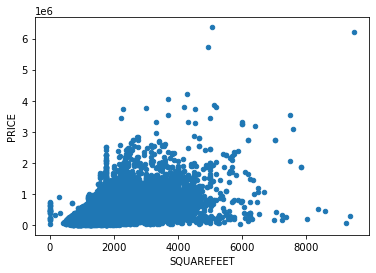

In [50]:
df.plot(kind="scatter", x="SQUAREFEET", y="PRICE")

In [51]:
df[df['SQUAREFEET']<600]['SQUAREFEET'].value_counts().sort_index()
#We want to remove houses listed with less than 176 as we can assume these are errors
df = df[df['SQUAREFEET']>=176]

0.0        21
1.0      1430
2.0     18424
3.0     22236
4.0     17927
5.0       503
6.0        74
7.0        16
8.0         3
9.0         2
10.0        4
Name: BEDS, dtype: int64

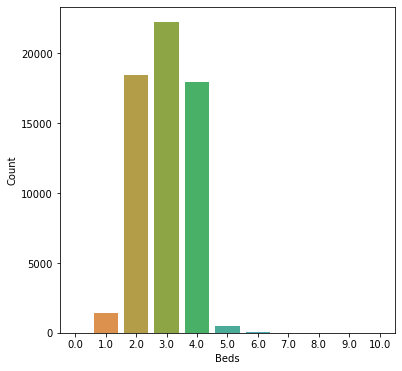

In [52]:
plt.figure(figsize=(6,6))
sns.countplot(df['BEDS'])
plt.xlabel('Beds')
plt.ylabel('Count')
df.BEDS.value_counts().sort_index(ascending=True)

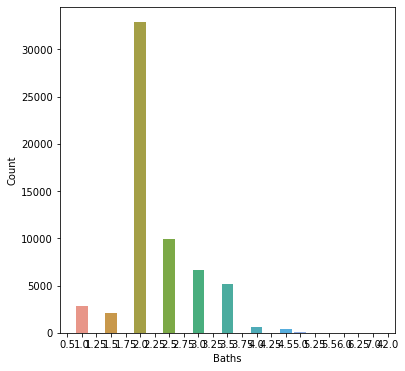

In [53]:
plt.figure(figsize=(6,6))
sns.countplot(df['BATHS'])
plt.xlabel('Baths')
plt.ylabel('Count')
df.BATHS.value_counts().sort_index(ascending=True)
#These are likely skewed data
df = df[df['BATHS'] <14]

### Price

<Figure size 432x288 with 0 Axes>

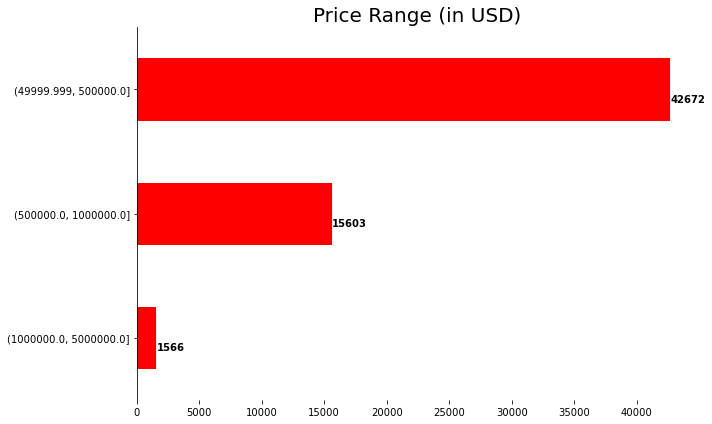

In [54]:
filter_values = [ 50000, 500000,1000000,5000000 ]
fig = plt.figure()
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
feq=df['PRICE'].value_counts(bins=filter_values).sort_values(ascending=True)
feq.plot.barh(figsize=(10,6), color="red", width=0.5)
plt.title("Price Range (in USD)", fontsize=20)
for i, v in enumerate(feq):
    ax.text(v + 10, i - 0.1, str(v), color="black", fontweight='bold')
plt.tight_layout()
plt.show()

In [55]:
# This is common function to calcuate the Interquartile range
def outlier_lower_iqr(col_name, th1=0.25, th3=0.75):
    quartile1 = df[col_name].quantile(th1)
    quartile3 = df[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit
def outlier_upper_iqr(col_name, th1=0.25, th3=0.75):
    quartile1 = df[col_name].quantile(th1)
    quartile3 = df[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    return upper_limit

In [56]:
#Remove Price Outliers
num_list=[ "PRICE"]

for i in num_list:
    df=df[df[i].between(outlier_lower_iqr(i), outlier_upper_iqr(i))]

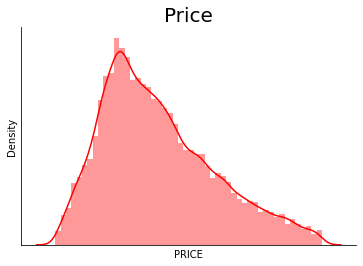

In [57]:
fig = plt.figure()
ax = sns.distplot(df['PRICE'], color="red")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.title("Price", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [58]:
print("Skewness of PRICE: {}".format(df['PRICE'].skew()))

Skewness of PRICE: 0.69176484881643


In [59]:
df1 =df.copy()

In [60]:
df1['PRICE'] = df1['PRICE'].apply(lambda x: math.log(x))

In [61]:
print("Skewness of PRICE: {}".format(df1['PRICE'].skew()))
#Data is more skewed when logged, will keep as is

Skewness of PRICE: -1.0600755278086744


# Modeling

In [62]:
RANDOM_SEED = 50

In [63]:
# splitting data into test and train based on SOLDDATE(YEAR)
X = df.loc[:, ['SOLDDATE', 'PROPERTYTYPE', 'CITY', 'ZIPORPOSTALCODE', 'BEDS', 'BATHS', 'LOCATION', 'SQUAREFEET', 'YEARBUILT',
       'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'AggregateCrime','PRICE']]
#Pre-covid prices should offset price increase in 2021/22 and show us pricing more in-line with 
#what we would have expected before covid and inflation
train_data=X[X['SOLDDATE']<6]
test_data=X[X['SOLDDATE']>=6]


X_train = train_data.drop(['PRICE'], axis = 1) 
X_test = test_data.drop(['PRICE'], axis = 1)
y_train = train_data["PRICE"]
y_test = test_data["PRICE"]

In [64]:
len(X_train), len(y_train), len(X_test), len(y_test), len(train_data)

(36308, 36308, 22642, 22642, 36308)

In [65]:
#Creating RMSE Scoring Function
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

In [66]:
rmse_score = make_scorer(rmse, greater_is_better = False)

In [67]:
from sklearn.model_selection import cross_val_score
# function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=5,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics

#### 1. Linear Regression

In [69]:
from sklearn.linear_model import LinearRegression
# Train model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# get cross val scores
get_cv_scores(lin_reg)

CV Mean:  0.3989215808881076
STD:  0.12281063943750667




Cross Validation score is low for linear regression try to improve using Ridge, Lasso, and Elastic Net.

In [70]:
prediction_linear = lin_reg.predict(X_test)
prediction_linear

array([440553.438, 450738.176, 367776.807, ..., 458195.029, 520987.618,
       552487.187])

In [71]:
linear_mse = metrics.mean_squared_error(y_test, prediction_linear)
linear_mse

20740750578.390293

In [72]:
linear_rmse = np.sqrt(linear_mse)
linear_rmse

144016.4941192164

In [73]:
lin_reg.score(X_train, y_train)

0.5650143541647097

In [74]:
rmse(y_test, prediction_linear)

144016.4941192164

#### 2. Ridge Regression

In [75]:
from sklearn.linear_model import Ridge
# Train model with default alpha=1
ridge = Ridge(alpha=1).fit(X_train, y_train)
# get cross val scores
get_cv_scores(ridge)

CV Mean:  0.39837795631797074
STD:  0.12319085852342118




CV mean still low

In [76]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring=rmse_score, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  -144869.69447140984
Best Params:  {'alpha': 0.001}


even with best parameters RMSE score largely negative

In [77]:
ridge.score(X_train, y_train)

0.5650034116140344

In [78]:
y_pred_rd = ridge.predict(X_test)
rmse(y_test, y_pred_rd)

144056.26715350393

#### 3. Lasso Regression

In [79]:
from sklearn.linear_model import Lasso
# Train model with default alpha=1
lasso = Lasso(alpha=1).fit(X_train, y_train)
# get cross val scores
get_cv_scores(lasso)

CV Mean:  0.39889457498486297
STD:  0.12283395997208628




CV mean similar to linear regression and ridge regression

In [80]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring=rmse_score, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  -144869.65809034143
Best Params:  {'alpha': 0.001}


even with best parameters RMSE score largely negative

In [81]:
lasso.score(X_train, y_train)

0.5650143265762596

In [82]:
y_pred_ls = lasso.predict(X_test)
rmse(y_test, y_pred_ls)

144018.76574124498

#### 4. Elastic Net

In [83]:
from sklearn.linear_model import ElasticNet
# Train model with default alpha=1 and l1_ratio=0.5
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5).fit(X_train, y_train)
# get cross val scores
get_cv_scores(elastic_net)

CV Mean:  0.15045291797487081
STD:  0.16695078639254476




CV mean is even lower for elastic net than linear regression and ridge resgression

In [84]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
l1_ratio = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
param_grid = dict(alpha=alpha, l1_ratio=l1_ratio)
grid = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring=rmse_score, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 77 candidates, totalling 385 fits
Best Score:  -144869.65809034143
Best Params:  {'alpha': 0.001, 'l1_ratio': 1}


In [85]:
elastic_net.score(X_train, y_train)

0.4125647448944205

In [86]:
y_pred_en = elastic_net.predict(X_test)
rmse(y_test, y_pred_en)

163907.31757268237

RMSE score is not optimal. 

#### 5. Decision Tree

In [87]:
criterion = ["mse", "mae"]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 20, 40, 100]
    
param_grid = {"criterion": criterion,
              "min_samples_split": min_samples_split,
              "min_samples_leaf": min_samples_leaf,
              }

In [88]:
# Use GridSearchCV to search for best hyperparameters
# First create the base model to tune  
decision_tree = DecisionTreeRegressor(random_state=RANDOM_SEED)
# Using 3 fold cross validation
grid_search = GridSearchCV(decision_tree, param_grid = param_grid, cv=3, scoring=rmse_score, n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=50), n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'min_samples_leaf': [1, 20, 40, 100],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [89]:
final = grid_search.best_params_
print(final)

{'criterion': 'mse', 'min_samples_leaf': 40, 'min_samples_split': 2}


In [90]:
dt = DecisionTreeRegressor(criterion= 'mse', min_samples_leaf= 40, min_samples_split= 2,random_state=RANDOM_SEED)

In [91]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', min_samples_leaf=40, random_state=50)

In [92]:
y_pred_dt = dt.predict(X_test)

In [93]:
print('RMSE Score:',rmse(y_test, y_pred_dt))

RMSE Score: 111232.67993545643


In [94]:
dt.score(X_train, y_train)

0.8728704288466927

In [95]:
get_cv_scores(dt)

CV Mean:  0.5829214005142463
STD:  0.15519415004688722




<Figure size 1800x1800 with 0 Axes>

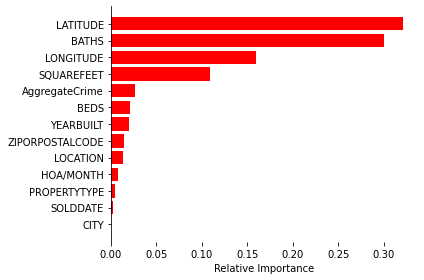

In [96]:
features = X_train.columns
importances = dt.feature_importances_
indices = np.argsort(importances)


fig = plt.figure(figsize=(25,25))
fig, ax = plt.subplots()
#plt.figure( figsize=(20,20) )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
plt.barh(range(len(indices)), importances[indices], align='center', color="red")
plt.yticks(range(len(indices)), [features[i] for i in indices]);
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

#### 6. Random Forest

In [97]:
# splitting data into test and train based on SOLDDATE(YEAR)
X = df.loc[:, ['SOLDDATE', 'PROPERTYTYPE', 'CITY', 'ZIPORPOSTALCODE', 'BEDS', 'BATHS', 'LOCATION', 'SQUAREFEET', 'YEARBUILT',
       'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'AggregateCrime','PRICE']]
#Pre-covid prices should offset price increase in 2021/22 and show us pricing more in-line with 
#what we would have expected before covid and inflation
train_data=X[X['SOLDDATE']<7]
test_data=X[X['SOLDDATE']>=6]


X_train = train_data.drop(['PRICE'], axis = 1) 
X_test = test_data.drop(['PRICE'], axis = 1)
y_train = train_data["PRICE"]
y_test = test_data["PRICE"]

In [98]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [99]:
# Use GridSearchCV to search for best hyperparameters
# First create the base model to tune
random_forest = RandomForestRegressor(random_state=RANDOM_SEED)
# Using 3 fold cross validation
rf_grid = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the random search model
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=50), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [100]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [101]:
rf = RandomForestRegressor(n_estimators= 300,
 min_samples_split=8,
 min_samples_leaf = 3,
 max_depth = 80,
 max_features = 3,
 bootstrap = True,
 random_state = RANDOM_SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=300, random_state=50)

In [102]:
y_pred_rf = rf.predict(X_test)

In [103]:
print('RMSE Score:',rmse(y_test, y_pred_rf))

RMSE Score: 60712.83203467007


In [104]:
rf.score(X_train, y_train)

0.9512593777650866

In [105]:
get_cv_scores(rf)

CV Mean:  0.7651046823019569
STD:  0.09694679053643365




# Modeling For Sale Data

In [106]:
dfp = pd.read_excel ('ForSale05222022.xlsx')

In [107]:
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2609 entries, 0 to 2608
Data columns (total 28 columns):
 #   Column                                                                                       Non-Null Count  Dtype  
---  ------                                                                                       --------------  -----  
 0   Source.Name                                                                                  2609 non-null   object 
 1   SALE TYPE                                                                                    2609 non-null   object 
 2   SOLD DATE                                                                                    0 non-null      float64
 3   PROPERTY TYPE                                                                                2609 non-null   object 
 4   ADDRESS                                                                                      2590 non-null   object 
 5   CITY                              

In [108]:
dfp.drop_duplicates(keep='first',inplace=True)

dfp=dfp.drop(['Source.Name','SALE TYPE','STATE OR PROVINCE','STATUS',
            'NEXT OPEN HOUSE START TIME',
            'NEXT OPEN HOUSE END TIME', 
            'FAVORITE', 
            'INTERESTED',
            'MLS#',
            'STATUS',
            'STATE OR PROVINCE',
            'URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',#has missing data
            'SOURCE',
            '$/SQUARE FEET'
           ], axis=1)

# remove special character as well as spaces in between column names
# removing them helps later in processing
dfp.columns = dfp.columns.str.replace(' ', '')

In [109]:
dfp = pd.merge(dfp, crimeCountindex, how='left', left_on='LOCATION', right_on='Community Area')
dfp.head()

SOLDDATE               PROPERTYTYPE                 ADDRESS     CITY  \
0       NaN                Condo/Co-op  749 S Claremont Ave #1  Chicago   
1       NaN                Condo/Co-op   2336 E 71st St Unit B  Chicago   
2       NaN                Condo/Co-op   4817 N Kimball Ave #1  Chicago   
3       NaN  Single Family Residential         8801 S Lowe Ave  Chicago   
4       NaN  Single Family Residential    8004 S Ingleside Ave  Chicago   

   ZIPORPOSTALCODE   PRICE  BEDS  BATHS              LOCATION  SQUAREFEET  \
0            60612  219900     2    2.0  CHI - Near West Side      1200.0   
1            60649  199999     2    2.5     CHI - South Shore      1300.0   
2            60625  249900     2    2.0     CHI - Albany Park      1250.0   
3            60620  230000     2    2.5  CHI - Auburn Gresham      1116.0   
4            60619  169900     3    2.5         CHI - Chatham      1513.0   

   LOTSIZE  YEARBUILT  DAYSONMARKET  HOA/MONTH   LATITUDE  LONGITUDE  \
0      NaN     1999.0           5.0      150.0  41.871724 -87.684661   
1      NaN     2010.0          10.0      295.0  41.766479 -87.568494   
2      NaN     1917.0          17.0      350.0  41.969008 -87.713140   
3   3136.0     1885.0          39.0        NaN  41.734214 -87.639671   
4   4138.0     1952.0          58.0        NaN  41.749261 -87.601773   

  Community Area AggregateCrime  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN

In [110]:
dfp=dfp.drop(['DAYSONMARKET','LOTSIZE','Community Area'],axis=1)
dfp['AggregateCrime']=dfp['AggregateCrime'].fillna(dfp['AggregateCrime'].median())

In [111]:
# converting the sold date field to a proper date time format
df['SOLDDATE'] = pd.to_datetime(df['SOLDDATE'])
df['SOLDDATE']=pd.DatetimeIndex(df['SOLDDATE']).year
df.dropna(subset = ['SOLDDATE'], inplace=True)
df['SOLDDATE']=df['SOLDDATE'].astype(int)

In [112]:
dfp['CITY'] = dfp.CITY.str.upper()
dfp = dfp[dfp['CITY'] != 'ARLINGTON HEIGHTS']

In [113]:
#Mapping data to numerical values
mapping_dict = {"PROPERTYTYPE":{
"Condo/Co-op": 1,
"Single Family Residential": 2,
"Townhouse": 3,
"Multi-Family (2-4 Unit)": 4,
"Multi-Family (5+ Unit)": 5,
"Other": 6,
"Vacant Land": 7,
"Parking":8
},
"CITY":{
'CHICAGO' : 1,
'OAK PARK' : 0,
'OAK LAWN' : 0,
'BERWYN' : 0,
'BURBANK' : 0,
'EVERGREEN PARK' : 0,
'ELMWOOD PARK' : 0,
'FOREST PARK' : 0,
'CICERO' : 0,
'RIVER FOREST' : 0,
'HOMETOWN' : 0,
'STICKNEY' : 0,
'LINCOLNWOOD' : 0,
'HARWOOD HEIGHTS' : 0,
'BRIDGEVIEW' : 0,
'SKOKIE' : 0,
'NORRIDGE' : 0,
'RIVERSIDE' : 0,
'NORTH RIVERSIDE' : 0,
'RIVER GROVE' : 0,
'BURNHAM' : 0,
'FOREST VIEW' : 0,
'RIVERDALE' : 0,
'CALUMET PARK' : 0,
'MELROSE PARK' : 0,
'NOTTINGHAM PARK' : 0,
'LAWNDALE' : 0,
'MAYWOOD' : 0,
'NILES' : 0},
"SOLDDATE":{
2016: 1,
2017: 2,
2018: 3,
2019: 4,
2020: 5,
2021: 6,
2022: 7    
}
               }
df = df.replace(mapping_dict)

In [114]:
dfp['PROPERTYTYPE'] = dfp['PROPERTYTYPE'].astype('str')
dfp['CITY'] = dfp['CITY'].astype('str')
dfp['LOCATION'] = dfp['LOCATION'].astype('str')
dfp['SOLDDATE'] = 7
dfp['SOLDDATE']=dfp['SOLDDATE'].astype(int)


catmap = preprocessing.LabelEncoder()
dfp['PROPERTYTYPE'] = catmap.fit_transform(dfp['PROPERTYTYPE'].values)
dfp['CITY'] = catmap.fit_transform(dfp['CITY'].values)
dfp['LOCATION'] = catmap.fit_transform(dfp['LOCATION'].values)
dfp['ZIPORPOSTALCODE'] = catmap.fit_transform(dfp['ZIPORPOSTALCODE'].values)
dfp['YEARBUILT'] = catmap.fit_transform(dfp['YEARBUILT'].values)

In [115]:
from sklearn.impute import SimpleImputer, KNNImputer
knniputer = KNNImputer()
knniputer.fit(dfp[["SQUAREFEET"]])
dfp["SQUAREFEET"] = knniputer.transform(dfp[["SQUAREFEET"]])
dfp["SQUAREFEET"] = dfp["SQUAREFEET"].apply(lambda x: int(x))

In [116]:
dfp['HOA/MONTH'] = dfp['HOA/MONTH'].fillna(0)

In [117]:
total = dfp.isnull().sum().sort_values(ascending=False)
percent_1 = dfp.isnull().sum()/dfp.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(33)

Total    %
ADDRESS             19  0.7
SOLDDATE             0  0.0
PROPERTYTYPE         0  0.0
CITY                 0  0.0
ZIPORPOSTALCODE      0  0.0
PRICE                0  0.0
BEDS                 0  0.0
BATHS                0  0.0
LOCATION             0  0.0
SQUAREFEET           0  0.0
YEARBUILT            0  0.0
HOA/MONTH            0  0.0
LATITUDE             0  0.0
LONGITUDE            0  0.0
AggregateCrime       0  0.0

In [118]:
x_pred = dfp.loc[:, ['SOLDDATE', 'PROPERTYTYPE', 'CITY', 'ZIPORPOSTALCODE', 'BEDS', 'BATHS', 'LOCATION', 'SQUAREFEET', 'YEARBUILT',
       'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'AggregateCrime']]
y_pred = dfp["PRICE"]

In [119]:
y_actual_predictions =  rf.predict(x_pred)
dff = pd.DataFrame({'ActualPrice': y_pred, 'PredictedPrice': y_actual_predictions})

# Reversing log normalization

#dff['PredictedPrice'] = dff['PredictedPrice'].apply(lambda x: np.exp(x))
#dff['ActualPrice'] = dff['ActualPrice'].apply(lambda x: np.exp(x))
dff=pd.concat([dff,x_pred], axis=1)
dff['PERCENTAGE']=round(((dff['PredictedPrice']-dff['ActualPrice'])/dff['ActualPrice'])*100, 2)

In [120]:
dff['PERCENTAGE'].value_counts()

 0.89     4
 19.10    4
-30.19    4
-28.03    4
-30.34    4
         ..
-5.03     1
-20.43    1
-29.10    1
-4.69     1
-21.98    1
Name: PERCENTAGE, Length: 2152, dtype: int64

<Figure size 432x288 with 0 Axes>

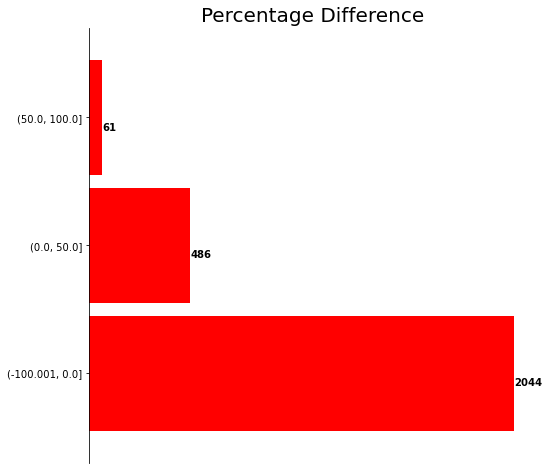

In [121]:
filter_values = [ -100, 0,  50, 100]
fig = plt.figure()
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
feq=dff['PERCENTAGE'].value_counts(bins=filter_values).sort_index()
feq.plot.barh(figsize=(8,8), color="red", width=0.9)
plt.title("Percentage Difference", fontsize=20)
for i, v in enumerate(feq):
    ax.text(v + 1, i - 0.1, str(v), color="black", fontweight='bold')
ax.set_xticks([])
plt.show()

In [122]:
badbuys=pd.DataFrame(dff[['LATITUDE', 'LONGITUDE']][dff['PERCENTAGE']<50])
goodbuys=pd.DataFrame(dff[['LATITUDE', 'LONGITUDE']][dff['PERCENTAGE']>=50])
goodbuyslocationlist = goodbuys.values.tolist()
badbuyslocationlist = badbuys.values.tolist()

In [123]:
map = folium.Map(location=[41.85, -87.68], zoom_start=12)
for point in range(0, len(goodbuyslocationlist)):
    folium.Marker(goodbuyslocationlist[point], icon=folium.Icon(color='green', icon='home')).add_to(map)
map

In [124]:
map = folium.Map(location=[41.85, -87.68], zoom_start=12)
for point in range(0, len(badbuyslocationlist)):
    folium.Marker(badbuyslocationlist[point], icon=folium.Icon(color='red', icon='home')).add_to(map)
map

# Costliest House

In [125]:
df.dropna(subset = ['PRICE'], inplace=True)
df['PRICE']=df['PRICE'].astype('int')
num_list=[ "PRICE"]

for i in num_list:
    df=df[df[i].between(outlier_lower_iqr(i), outlier_upper_iqr(i))]
highest=pd.DataFrame(df.nlargest(5, 'PRICE'))
costliest=pd.DataFrame(highest[['LATITUDE', 'LONGITUDE']])
costliestlist = costliest.values.tolist()

In [126]:
map = folium.Map(location=[41.85, -87.68], zoom_start=12)
for point in range(0, len(costliestlist)):
    folium.Marker(costliestlist[point], icon=folium.Icon(color='red', icon='home')).add_to(map)
map